In [2]:
# Complete code for PCA vs VIF comparison in recession prediction with regression tables

# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn import metrics
import os 

# Load and preprocess data (CHANGE DIRECTORY FOR REPLICATION)
df = pd.read_csv('/Users/rfernex/Documents/Education/SciencesPo/Courses/CSS/Projects/Financial Recession Project/Data/Processed/macrodata.csv') # Change directory

# Remove index column and prepare target variable
df = df.drop("Unnamed: 0", axis=1)
df['Regime'] = df['Regime'].map({'Normal': 0, 'Recession': 1})

# Standardize features
X = df.drop('Regime', axis=1)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [3]:
# PCA Approach

# Hardcodes which indicators are financial and which are not 
financial_cols = ['FEDFUNDS', 'TB3MS', 'TB6MS', 'GS1', 'GS5', 'GS10', 'AAA', 
                 'TB3SMFFM', 'T1YFFM', 'AAAFFM', 'SP500', 'NASDAQ', 'GOLDBAR', 'P/E', 'Dividend Yield']
non_financial_cols = [col for col in X.columns if col not in financial_cols]

# Apply PCA separately to financial and non-financial indicators
pca_financial = PCA(n_components=4)
pca_non_financial = PCA(n_components=4)

financial_pca = pd.DataFrame(
    pca_financial.fit_transform(X_scaled[financial_cols]),
    columns=[f'FIN_PC{i+1}' for i in range(4)]
)
non_financial_pca = pd.DataFrame(
    pca_non_financial.fit_transform(X_scaled[non_financial_cols]),
    columns=[f'NFIN_PC{i+1}' for i in range(4)]
)

# Combine PCA components
X_combined = pd.concat([financial_pca, non_financial_pca], axis=1)

# Split data for PCA approach
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, df['Regime'], train_size=0.6, random_state=0, stratify=df['Regime']
)

# Fit Logistic Regression for PCA approach
logit_model = sm.Logit(y_train, add_constant(X_train))
results_PCA = logit_model.fit()

# Print PCA regression results
print("PCA Logistic Regression Results:")
print(results_PCA.summary())

output_dir = "/Users/rfernex/Documents/Education/SciencesPo/Courses/CSS/Projects/Financial Recession Project/Output"  # Change directory

# Save regression results to txt file
with open(os.path.join(output_dir, "PCA_regression_results.txt"), 'w') as f:
    f.write("PCA Logistic Regression Results:\
")
    f.write(results_PCA.summary().as_text())


Optimization terminated successfully.
         Current function value: 0.183550
         Iterations 9
PCA Logistic Regression Results:
                           Logit Regression Results                           
Dep. Variable:                 Regime   No. Observations:                  175
Model:                          Logit   Df Residuals:                      166
Method:                           MLE   Df Model:                            8
Date:                Wed, 22 Jan 2025   Pseudo R-squ.:                  0.4460
Time:                        16:45:16   Log-Likelihood:                -32.121
converged:                       True   LL-Null:                       -57.980
Covariance Type:            nonrobust   LLR p-value:                 1.908e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4693      0.586     -5.925      0.000      -4.617      -2.

In [4]:
# Generate predictions for PCA approach
y_pred_prob = results_PCA.predict(add_constant(X_test))

# Calculate ROC curve for PCA approach
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)

In [5]:
# VIF Approach
# Calculate VIF scores
X_with_constant = add_constant(X_scaled)
vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_constant.values, i) 
                   for i in range(X_with_constant.shape[1])]

# Select features with VIF < 100
selected_features = vif_data[(vif_data['VIF'] < 100) & (vif_data['Variable'] != 'const')]['Variable'].tolist()
X_vif = X_scaled[selected_features]

# Split data for VIF approach
X_train_vif, X_test_vif, y_train_vif, y_test_vif = train_test_split(
    X_vif, df['Regime'], train_size=0.6, random_state=0, stratify=df['Regime']
)

# Fit Logistic Regression for VIF-selected features
logit_model_vif = sm.Logit(y_train_vif, add_constant(X_train_vif))
results_vif = logit_model_vif.fit()

# Print VIF regression results
print("\
VIF Logistic Regression Results:")
print(results_vif.summary())

output_dir = "/Users/rfernex/Documents/Education/SciencesPo/Courses/CSS/Projects/Financial Recession Project/Output"  # Change directory

# Save regression results to txt file
with open(os.path.join(output_dir, "VIF_regression_results.txt"), 'w') as f:
    f.write("PCA Logistic Regression Results:\
")
    f.write(results_vif.summary().as_text())


Optimization terminated successfully.
         Current function value: 0.109981
         Iterations 11
VIF Logistic Regression Results:
                           Logit Regression Results                           
Dep. Variable:                 Regime   No. Observations:                  175
Model:                          Logit   Df Residuals:                      164
Method:                           MLE   Df Model:                           10
Date:                Wed, 22 Jan 2025   Pseudo R-squ.:                  0.6680
Time:                        16:45:16   Log-Likelihood:                -19.247
converged:                       True   LL-Null:                       -57.980
Covariance Type:            nonrobust   LLR p-value:                 1.572e-12
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -7.3426      1.943     -3.778      0.000     -11

/Users/rfernex/Documents/Education/SciencesPo/Courses/CSS/Coding_Softwares/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [6]:
# Generate predictions for VIF approach
y_pred_prob_vif = results_vif.predict(add_constant(X_test_vif))

# Calculate ROC curve for VIF approach
fpr_vif, tpr_vif, _ = metrics.roc_curve(y_test_vif, y_pred_prob_vif)

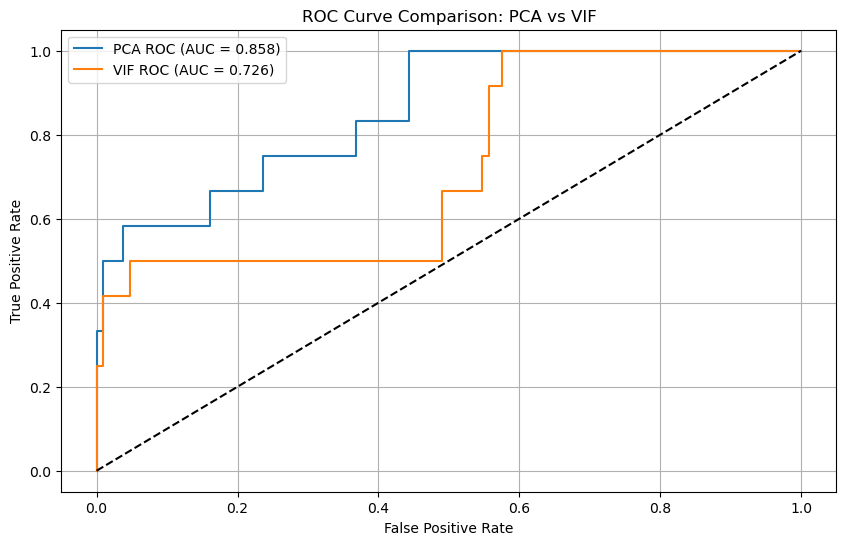

<Figure size 640x480 with 0 Axes>

In [7]:
# Plot ROC curves for both approaches
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'PCA ROC (AUC = {metrics.auc(fpr, tpr):.3f})')
plt.plot(fpr_vif, tpr_vif, label=f'VIF ROC (AUC = {metrics.auc(fpr_vif, tpr_vif):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: PCA vs VIF')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('/Users/rfernex/Documents/Education/SciencesPo/Courses/CSS/Projects/Financial Recession Project/Output/ROC_curves.png') # Change directory


In [8]:
# PCA Metrics
pca_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC Score'],
    'Score': [
        metrics.accuracy_score(y_test, y_pred_prob > 0.5),
        metrics.precision_score(y_test, y_pred_prob > 0.5),
        metrics.recall_score(y_test, y_pred_prob > 0.5),
        metrics.f1_score(y_test, y_pred_prob > 0.5),
        metrics.auc(fpr, tpr)
    ]
})

# VIF Metrics
vif_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC Score'],
    'Score': [
        metrics.accuracy_score(y_test_vif, y_pred_prob_vif > 0.5),
        metrics.precision_score(y_test_vif, y_pred_prob_vif > 0.5),
        metrics.recall_score(y_test_vif, y_pred_prob_vif > 0.5),
        metrics.f1_score(y_test_vif, y_pred_prob_vif > 0.5),
        metrics.auc(fpr_vif, tpr_vif)
    ]
})

# Save tables (Change directory)
with open('/Users/rfernex/Documents/Education/SciencesPo/Courses/CSS/Projects/Financial Recession Project/Output/PCA_metrics.txt', 'w') as f:
    f.write('PCA Model Statistics:\
')
    f.write(pca_metrics.to_string(index=False))
with open('/Users/rfernex/Documents/Education/SciencesPo/Courses/CSS/Projects/Financial Recession Project/Output/VIF_metrics.txt', 'w') as f:
    f.write('PCA Model Statistics:\
')
    f.write(vif_metrics.to_string(index=False))


# Display tables
print("PCA Metrics:")
print(pca_metrics.to_string(index=False))
print("\
VIF Metrics:")
print(vif_metrics.to_string(index=False))

PCA Metrics:
   Metric    Score
 Accuracy 0.932203
Precision 0.833333
   Recall 0.416667
 F1 Score 0.555556
AUC Score 0.857704
VIF Metrics:
   Metric    Score
 Accuracy 0.923729
Precision 0.714286
   Recall 0.416667
 F1 Score 0.526316
AUC Score 0.726415


In [9]:
# Print selected features for VIF approach
print("\
Features selected by VIF approach:")
print(selected_features)

# Create a DataFrame with coefficients and p-values for both models
def get_model_stats(results, model_name):
    coef = results.params
    pvalues = results.pvalues
    conf_int = results.conf_int()
    
    stats_df = pd.DataFrame({
        'Model': model_name,
        'Variable': coef.index,
        'Coefficient': coef.values,
        'P-value': pvalues.values,
        'CI Lower': conf_int[0].values,
        'CI Upper': conf_int[1].values
    })
    return stats_df

# Get statistics for both models
pca_stats = get_model_stats(results_PCA, 'PCA')
vif_stats = get_model_stats(results_vif, 'VIF')

# Save tables (Change directory)
with open('/Users/rfernex/Documents/Education/SciencesPo/Courses/CSS/Projects/Financial Recession Project/Output/PCA_stats.txt', 'w') as f:
    f.write('PCA Model Statistics:\
')
    f.write(pca_stats.to_string(index=False))

with open('/Users/rfernex/Documents/Education/SciencesPo/Courses/CSS/Projects/Financial Recession Project/Output/VIF_stats.txt', 'w') as f:
    f.write('VIF Model Statistics:\
')
    f.write(vif_stats.to_string(index=False))


# Combine and display the results
print("\
Detailed Model Statistics:")
print("\
PCA Model Coefficients and P-values:")
print(pca_stats.round(4))
print("\
VIF Model Coefficients and P-values:")
print(vif_stats.round(4))

Features selected by VIF approach:
['HOUST', 'PERMIT', 'TOTRESNS', 'DTCTHFNM', 'EXSZUS', 'EXCAUS', 'EXUSUK', 'GOLDBAR', 'P/E', 'Dividend Yield']
Detailed Model Statistics:
PCA Model Coefficients and P-values:
  Model  Variable  Coefficient  P-value  CI Lower  CI Upper
0   PCA     const      -3.4693   0.0000   -4.6170   -2.3216
1   PCA   FIN_PC1       0.2690   0.7315   -1.2676    1.8056
2   PCA   FIN_PC2      -1.3409   0.1536   -3.1827    0.5009
3   PCA   FIN_PC3      -1.6333   0.0019   -2.6658   -0.6007
4   PCA   FIN_PC4       0.4831   0.2353   -0.3147    1.2808
5   PCA  NFIN_PC1       0.5291   0.3623   -0.6092    1.6674
6   PCA  NFIN_PC2      -0.7867   0.0594   -1.6046    0.0311
7   PCA  NFIN_PC3      -0.3678   0.3297   -1.1073    0.3718
8   PCA  NFIN_PC4       0.8395   0.4048   -1.1357    2.8147
VIF Model Coefficients and P-values:
   Model        Variable  Coefficient  P-value  CI Lower  CI Upper
0    VIF           const      -7.3426   0.0002  -11.1517   -3.5334
1    VIF           H